## Análisis de las ventas de desodorantes en aerosol 

In [87]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plot_functions import plot_sales_chart, plot_piechart, plot_scatter, plot_box

In [88]:
deodorants_df = pd.read_csv("../clean_data/deodorants_final_merged.csv",
                            parse_dates=['fecha_trans'])

In [89]:
deodorants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8356436 entries, 0 to 8356435
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   idb                     int64         
 1   id_producto             int64         
 2   fecha_trans             datetime64[ns]
 3   stock_unidades          int64         
 4   venta_unidades          int64         
 5   precio_unitario         float64       
 6   sigue_prod_en_rol       int64         
 7   cd_abast                int64         
 8   mov_month               int64         
 9   mov_year                int64         
 10  mov_weekday             int64         
 11  ventas_estimadas_promo  int64         
 12  nro_prom                int64         
 13  duracion_promo          int64         
 14  id_cadena               int64         
 15  desc_cadena             object        
 16  longitud                float64       
 17  latitud                 float64       
 18  lo

In [91]:
# check for null or NaN values in each column
null_cols = deodorants_df.isnull().any()

# print columns with null or NaN values
print(null_cols[null_cols == True].index.tolist())

[]


In [92]:
# Total sales with negative values
print(
    f'Total de ventas con valores negativos: {deodorants_df[deodorants_df["venta_unidades"] < 0]["venta_unidades"].count()}'
)

Total de ventas con valores negativos: 580


In [93]:
# Delete sales with negative values
deodorants_df = deodorants_df[deodorants_df['venta_unidades'] >= 0]

In [94]:
# Total columns after removing negative sales
print(
    f'Total de ventas con valores negativos: {deodorants_df[deodorants_df["venta_unidades"] < 0]["venta_unidades"].count()}'
)

Total de ventas con valores negativos: 0


In [95]:
# Total columns after removing negative sales
print(
    f'Total dataset sin los valores negativos de ventas: {len(deodorants_df)}')

Total dataset sin los valores negativos de ventas: 8355856


In [181]:
grouped_data = deodorants_df.groupby(['idb'
                                      ]).venta_unidades.count().reset_index()
grouped_data

,idb,venta_unidades
0,242,28452
1,247,56697
2,249,41863
3,252,21088
4,257,74383
...,...,...
137,9704,66231
138,9706,66730
139,9942,69347
140,9973,28658


In [187]:
# Before replacement
neg_count = deodorants_df[
    deodorants_df['stock_unidades'] < 0]['stock_unidades'].count()
print(f"Total de stock con valor negativo: {neg_count}")

# Replacing negative values with 0
deodorants_df.loc[deodorants_df['stock_unidades'] < 0, 'stock_unidades'] = 0

# After replacement
neg_count = deodorants_df[
    deodorants_df['stock_unidades'] < 0]['stock_unidades'].count()
print(
    f"Total de stock con valor negativo después de reemplazar con 0: {neg_count}"
)

Total de stock con valor negativo: 0
Total de stock con valor negativo después de reemplazar con 0: 0


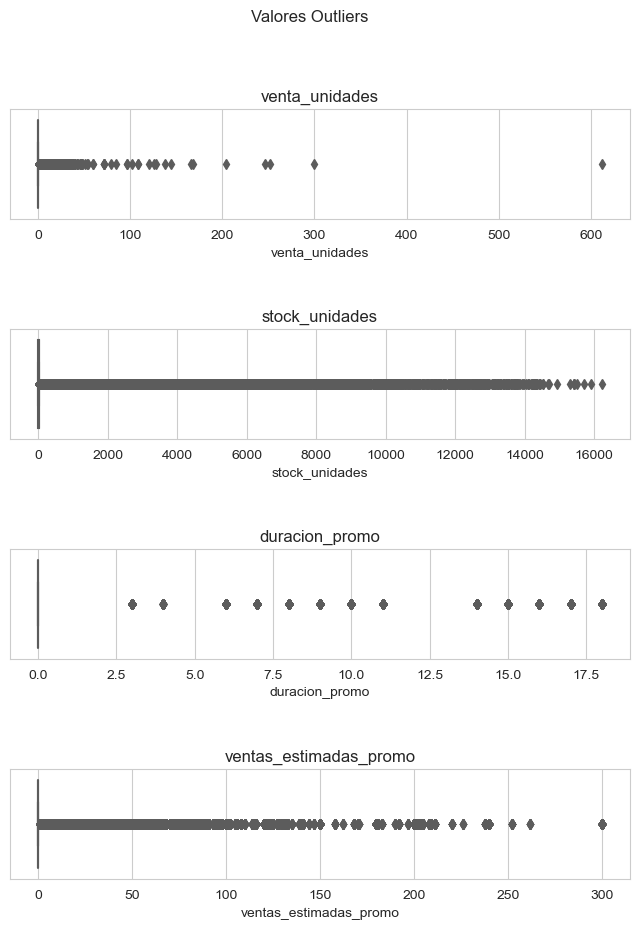

In [188]:
cols_num = [
    'venta_unidades', 'stock_unidades', 'duracion_promo',
    'ventas_estimadas_promo'
]
plot_box(deodorants_df,
         cols_num,
         title='Valores Outliers',
         figsize=(8, 10),
         nrows=4,
         savefig='valores_outliers')

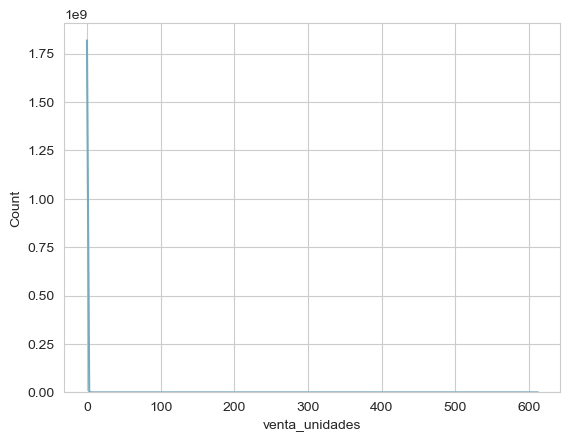

In [189]:
import seaborn as sns

sns.histplot(data=deodorants_df, x="venta_unidades", kde=True)
plt.savefig("ventas_hist.png")

In [192]:
def get_zone(latitude, longitude):
    """
    Assigns a zone number to a given latitude and longitude coordinate.

    Args:
        latitude (float): The latitude coordinate.
        longitude (float): The longitude coordinate.

    Returns:
        zone (int): The zone number for the given coordinates.
    """
    if latitude >= -34.0 and longitude >= -58.0:
        return 1
    elif latitude >= -34.0 and longitude < -58.0:
        return 2
    elif latitude < -34.0 and longitude >= -58.0:
        return 3
    else:
        return 4

In [193]:
backup = deodorants_df.copy()

In [194]:
deodorants_df['zona'] = deodorants_df.apply(
    lambda x: get_zone(x['latitud'], x['longitud']), axis=1)

In [195]:
ventas_by_zone_and_local = deodorants_df.groupby(
    ['zona', 'idb'])['venta_unidades'].sum().reset_index()
ventas_by_zone_and_local = ventas_by_zone_and_local.sort_values(
    by='venta_unidades', ascending=False)
ventas_by_zone_and_local

,zona,idb,venta_unidades
47,4,5202,95129
50,4,5206,85398
53,4,5211,68726
48,4,5204,62988
52,4,5208,58303
...,...,...,...
35,4,285,2870
73,4,9011,2071
39,4,707,1018
61,4,5276,881


In [196]:
ventas_by_zone = deodorants_df.groupby([
    'zona'
])['venta_unidades'].sum().reset_index().sort_values(by='venta_unidades',
                                                      ascending=False)
ventas_by_zone

,zona,venta_unidades
3,4,2166156
2,3,306298
1,2,122612
0,1,26624


In [197]:
# Filter the rows that need to be deleted
to_delete = deodorants_df.loc[
    (deodorants_df.venta_unidades == 0) & 
    (deodorants_df.desc_producto == 'missing') &
    (deodorants_df.razon_social == 'unknown') &
    (deodorants_df.stock_unidades == 0) &
    (deodorants_df.tiene_promo == 0) &
    (deodorants_df.nro_prom == 0.0) 
    
]

# Get the count of rows to be deleted
count_to_delete = len(to_delete)

# Delete the rows from the original dataframe
deodorants_df.drop(to_delete.index, inplace=True)

print(f'size before deleting: {len(deodorants_df)}')
print(f'Rows to delete: {count_to_delete}')
print(f'size after deleting: {len(deodorants_df)}')

size before deleting: 8272128
Rows to delete: 0
size after deleting: 8272128


In [199]:
filtered_df = deodorants_df[[
    'stock_unidades', 'venta_unidades', 'ventas_estimadas_promo',
    'precio_unitario', 'duracion_promo'
]]

In [200]:
deodorants_df.describe()

,idb,id_producto,stock_unidades,venta_unidades,precio_unitario,sigue_prod_en_rol,cd_abast,mov_month,mov_year,mov_weekday,...,duracion_promo,id_cadena,longitud,latitud,local,punto_dist,id_region,is_weekend,tiene_promo,zona
count,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,...,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06,8.272128e+06
mean,6.991175e+03,3.781817e+05,2.088143e+01,3.169305e-01,6.446128e+01,9.609215e-01,5.464377e+03,6.480312e+00,2.017672e+03,3.002376e+00,...,1.500399e-01,4.274465e+00,-5.872817e+01,-3.506349e+01,9.899061e-01,1.009390e-02,9.377802e-01,2.866678e-01,1.647339e-02,3.717005e+00
std,3.299621e+03,9.161289e+04,1.494613e+02,8.990582e-01,6.604925e+01,1.937817e-01,4.528327e+03,3.452697e+00,9.807317e-01,2.000168e+00,...,1.246558e+00,2.617869e+00,1.394333e+00,2.035385e+00,9.996004e-02,9.996004e-02,2.415543e-01,4.522051e-01,1.272872e-01,6.449873e-01
min,2.420000e+02,1.641460e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.016000e+03,0.000000e+00,...,0.000000e+00,2.000000e+00,-6.749604e+01,-4.587265e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,5.211000e+03,2.929450e+05,6.000000e+00,0.000000e+00,2.251000e+01,1.000000e+00,0.000000e+00,3.000000e+00,2.017000e+03,1.000000e+00,...,0.000000e+00,2.000000e+00,-5.869611e+01,-3.498957e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,9.026000e+03,4.152680e+05,1.000000e+01,0.000000e+00,3.823000e+01,1.000000e+00,9.217000e+03,6.000000e+00,2.018000e+03,3.000000e+00,...,0.000000e+00,4.000000e+00,-5.846482e+01,-3.462789e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,9.159000e+03,4.583930e+05,1.700000e+01,0.000000e+00,7.895000e+01,1.000000e+00,9.217000e+03,1.000000e+01,2.018000e+03,5.000000e+00,...,0.000000e+00,4.000000e+00,-5.839790e+01,-3.457732e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00
max,9.977000e+03,5.113260e+05,1.621800e+04,6.120000e+02,4.238100e+02,1.000000e+00,9.217000e+03,1.200000e+01,2.019000e+03,6.000000e+00,...,1.800000e+01,9.000000e+00,-5.668353e+01,-2.914198e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [201]:
stats = filtered_df.describe()

In [218]:
stats = stats.round(3)

# Create a Plotly table
table = go.Table(
    header=dict(values=['Statistic'] + list(stats.columns),
                fill_color="lightsteelblue",
                font=dict(color='white', size=14),
                align='center'),
    cells=dict(
        values=[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']] +
        [stats[col] for col in stats.columns],
        fill_color='#f2f2f2',
        font=dict(color='#404040', size=12),
        align='center'))

# Create a layout for the table
layout = go.Layout(width=900, height=500)

# Create a figure object with the table and layout
fig = go.Figure(data=[table], layout=layout)

# Save the figure as an image file
pio.write_image(fig, 'images/deodorants_stats.png')

In [203]:
deodorants_df.to_csv('../clean_data/deodorants_final_merged_v1.csv', index=False)

In [213]:
deodorants_df.shape

(8272128, 28)

In [216]:
deod_df = pd.read_csv("../clean_data/deodorants_final_merged_v1.csv",
                            parse_dates=['fecha_trans'])

In [217]:
deod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8272128 entries, 0 to 8272127
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   idb                     int64         
 1   id_producto             int64         
 2   fecha_trans             datetime64[ns]
 3   stock_unidades          int64         
 4   venta_unidades          int64         
 5   precio_unitario         float64       
 6   sigue_prod_en_rol       int64         
 7   cd_abast                int64         
 8   mov_month               int64         
 9   mov_year                int64         
 10  mov_weekday             int64         
 11  ventas_estimadas_promo  int64         
 12  nro_prom                int64         
 13  duracion_promo          int64         
 14  id_cadena               int64         
 15  desc_cadena             object        
 16  longitud                float64       
 17  latitud                 float64       
 18  lo

### Preguntas

- ¿Cuáles son los productos con mayor volumen de ventas?

In [205]:
product_grouped_top10 = deod_df.groupby(
    ['id_producto', 'desc_producto',
     'razon_social'])['venta_unidades'].sum().sort_values(
         ascending=False).nlargest(10).reset_index()
product_grouped_top10

,id_producto,desc_producto,razon_social,venta_unidades
0,342686,glade desodorante de ambientes lavander nueva ...,s. c. johnson y son de arg. s.a.,109539
1,240911,poett ambiental lavanda nuevo d 0.377 kg,clorox argentina s.a.,100884
2,429883,glade desodorante de ambientes ocean oasis nue...,s. c. johnson y son de arg. s.a.,89352
3,249486,glade toque rep lavandax2 9gr/6 lavanda 9 grm,s. c. johnson y son de arg. s.a.,86759
4,342745,glade desodorante de ambientes jazmin nueva fo...,s. c. johnson y son de arg. s.a.,72912
5,228217,glade toque rep limon 12mlx12 repuesto 12 mlt,s. c. johnson y son de arg. s.a.,68818
6,242234,poett ambiental suavidad de algodon nuevo d 0....,clorox argentina s.a.,68093
7,447299,glade desodorante de ambientes paraiso azul 1 ...,s. c. johnson y son de arg. s.a.,66328
8,292949,glade toque desodorante de ambientes ma�ana ca...,s. c. johnson y son de arg. s.a.,64383
9,242231,poett ambiental primavera nuevo d 0.377 kg,clorox argentina s.a.,62059


In [207]:
product_grouped_top10['desc_producto'] = product_grouped_top10[
    'desc_producto'].replace(to_replace='ma�ana', value='manana', regex=True)

In [208]:
product_grouped_bottom10 = deod_df.groupby(
    ['id_producto', 'desc_producto',
     'razon_social'])['venta_unidades'].sum().sort_values(
         ascending=False).nsmallest(10).reset_index()
product_grouped_bottom10

,id_producto,desc_producto,razon_social,venta_unidades
0,511325,missing,unknown,1983
1,284013,missing,unknown,2564
2,466069,glade toque aromatizante de ambientes campos l...,s. c. johnson y son de arg. s.a.,2816
3,511324,pure aerosol air wick cherry blossom 250.00 mlt,reckitt benckiser argentina s.a.,2927
4,511326,air wick pure aerosol soft cotton 250.00 mlt,reckitt benckiser argentina s.a.,3063
5,485719,missing,unknown,3181
6,284012,air wick citrico full rep.gratis 250.00 mlt,reckitt benckiser argentina s.a.,3660
7,415268,freshmatic bosque magico aparato air wick lush...,reckitt benckiser argentina s.a.,4176
8,164146,missing,unknown,5182
9,469286,exotic scents full air wick freshmatic 250.00 mlt,reckitt benckiser argentina s.a.,5576


In [209]:
# concatenate the id_producto and desc_producto columns
product_grouped_bottom10['desc_producto'] = product_grouped_bottom10.apply(
    lambda row: 'id_prod:' + str(row['id_producto']) + ' - ' + row[
        'desc_producto'],
    axis=1)

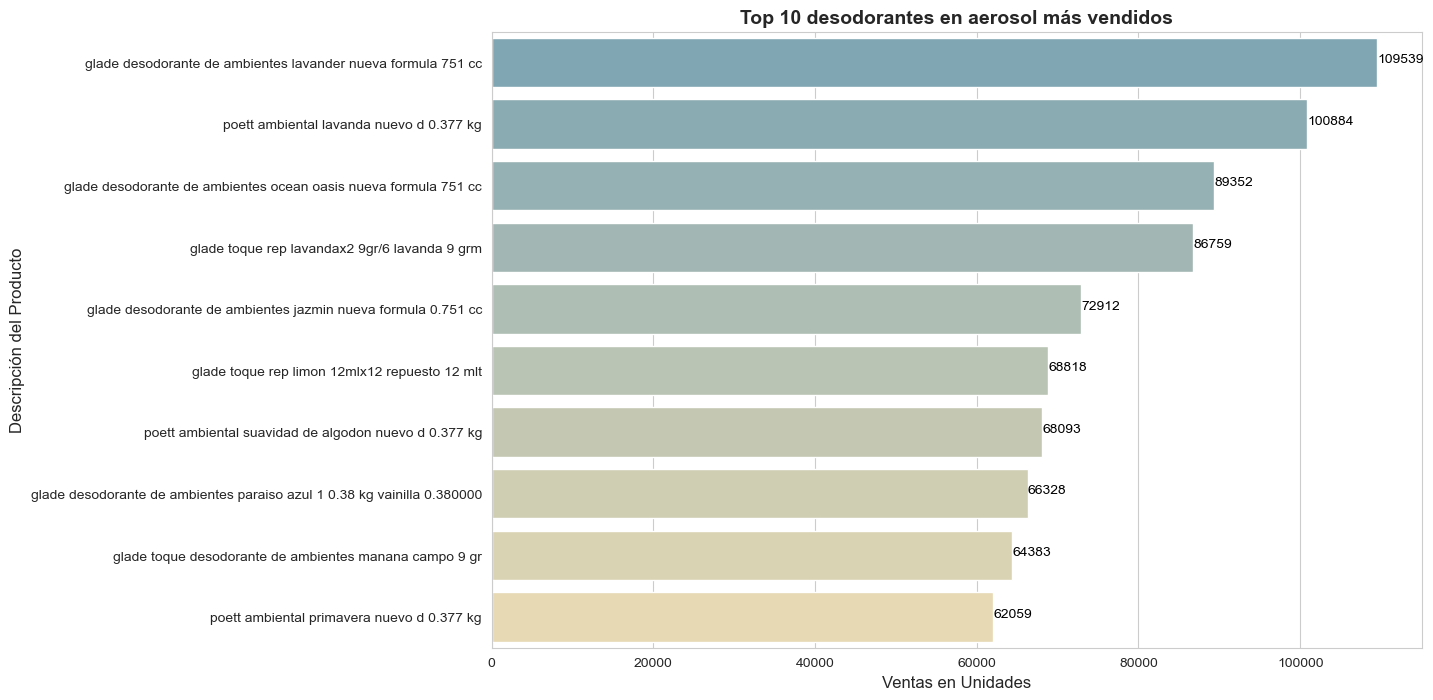

In [210]:
plot_sales_chart(product_grouped_top10,
                 'Top 10 desodorantes en aerosol más vendidos',
                 'ventas_desodorantes_top10', 'venta_unidades',
                 'desc_producto', 'venta_unidades', 'Ventas en Unidades',
                 'Descripción del Producto')

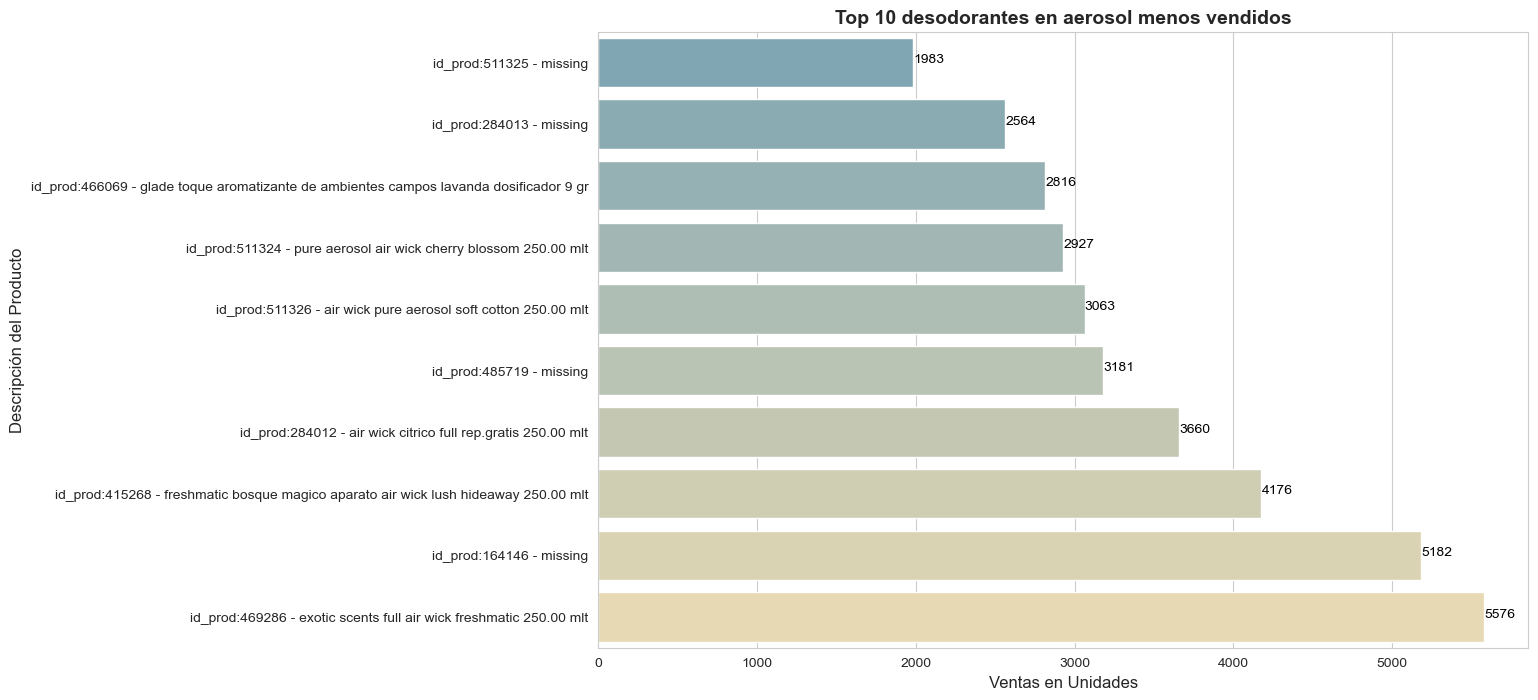

In [211]:
plot_sales_chart(product_grouped_bottom10,
                 'Top 10 desodorantes en aerosol menos vendidos',
                 'ventas_desodorantes_bot10', 'venta_unidades',
                 'desc_producto', 'venta_unidades', 'Ventas en Unidades',
                 'Descripción del Producto')

In [ ]:
# "Ventas rezagadas" o "ventas desfasadas" se refiere a las ventas de un producto en un periodo de
#tiempo anterior, que se utilizan como predictor para las ventas futuras. Por ejemplo, si queremos
#predecir las ventas de un producto en el mes actual, podemos utilizar las ventas del mes anterior
#como una característica de entrada para nuestro modelo de predicción. Esto se llama una característica
#de ventas rezagadas o desfasadas, ya que representa las ventas que ocurrieron en un periodo de tiempo anterior al que estamos tratando de predecir. El uso de características de ventas rezagadas puede ser útil para capturar
#patrones de ventas estacionales o para predecir el impacto de eventos pasados en las ventas futuras.
# Calculate the lagged sales feature (in this case, using a lag of 7 days)
deod_df['ventas_rezagadas'] = deod_df['venta_unidades'].shift(7)

# Calculate the average sales for each day of the week
daily_sales = deod_df.groupby('dia_semana')['venta_unidades'].mean()

# Normalize the sales data by dividing each observation by the corresponding average sales value
sales_data['seasonality'] = deod_df['venta_unidades'] / daily_sales[
    sales_data['dia_semana']].values

daily_sales

Esta lista de 16 productos tienen ventas zero y nunca han tenido una promoción por lo tanto las vamos a eliminar del dataset. 

In [ ]:
# Group the DataFrame by 'id_producto' and 'tiene_promo', and count the number of rows for each group
promo_counts = deod_df.groupby(['id_producto', 'tiene_promo'
                                      ]).size().reset_index(name='count')

# Create a Boolean Series indicating if a product has a count for both 'tiene_promo' values
has_both_promos = promo_counts.groupby(
    'id_producto')['tiene_promo'].count() == 2

# Filter the DataFrame to get the products that do not have a count for either 'tiene_promo' value
no_promos = promo_counts[~promo_counts['id_producto'].
                         isin(has_both_promos[has_both_promos].index)]

# Get the unique products IDs that do not have a count for either 'tiene_promo' value
no_promo_products = no_promos['id_producto'].unique()

no_promo_products

In [ ]:
deodorants_without_promo = deod_df[deodorants_df['id_producto'].isin(
    no_promo_products)]
deodorants_without_promo

In [141]:
# filter the dataframe based on venta_unidades == 0
ventas_zero_df = deod_df[deodorants_df['venta_unidades'] == 0]

# group the resulting dataframe by id_producto and desc_producto, and sum the units sold
ventas_zero_grouped = ventas_zero_df.groupby(['id_producto', 'desc_producto'
                                              ])['venta_unidades'].sum()

# reset the index to convert the resulting series to a dataframe
ventas_zero_df = ventas_zero_grouped.reset_index()

ventas_zero_df

,id_producto,desc_producto,venta_unidades
0,164146,missing,0
1,164149,glade toque rep lavanda 9gr/12 ar 9 grm,0
2,228217,glade toque rep limon 12mlx12 repuesto 12 mlt,0
3,228683,glade toque full limon 12mlx12 ar 12 mlt,0
4,238237,poett lavanda full ab nuevo 0.040 kg,0
...,...,...,...
87,507528,glade refrescantes ambientales-electricos auto...,0
88,507832,poett aerosol desodorante ambiental despertar ...,0
89,511324,pure aerosol air wick cherry blossom 250.00 mlt,0
90,511325,missing,0


In [ ]:
# print the resulting dataframe
result = ventas_zero_df[ventas_zero_df['desc_producto'] == 'unknown']
result

In [ ]:
unknown = deod_df['desc_producto']
unknown

In [ ]:
# filter ventas_zero_df based on the condition that id_producto is in no_promo_products list
ventas_zero_in_no_promos = ventas_zero_df[ventas_zero_df['id_producto'].isin(
    no_promo_products)]

# print the resulting dataframe
ventas_zero_in_no_promos

In [ ]:
# create a boolean mask indicating which rows in deodorants_df have an id_producto that is present in ventas_zero_in_no_promos
mask = deod_df['id_producto'].isin(
    ventas_zero_in_no_promos['id_producto'])

# create a new dataframe without the rows that meet the condition
deodorants_df_filtered = deod_df[~mask]

# print the resulting dataframe
len(deodorants_df_filtered)

In [ ]:
import folium

# Combine the latitude and longitude columns into a list of locations
locations = [[
    lat, lon
] for lat, lon in zip(deod_df['latitud'], deod_df['longitud'])]

# Define the bounds of the image
lat_min, lon_min = min(deod_df['latitud']), min(
    deodorants_df['longitud'])
lat_max, lon_max = max(deod_df['latitud']), max(
    deodorants_df['longitud'])
img_bounds = [[lat_min, lon_min], [lat_max, lon_max]]

# Create a map centered at the first location in the list
m = folium.Map(location=locations[0], zoom_start=5)

# Add markers to the map for each location in the list
for location in locations:
    folium.Marker(location=location).add_to(m)

m